In [1]:
! pip install -U category_encoders
! pip install -U scikit-learn
! pip install -U PDPbox
! pip install -U shap

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.7/dist-packages (2.2.2)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
Requirement already up-to-date: PDPbox in /usr/local/lib/python3.7/dist-packages (0.2.1)
Requirement already up-to-date: shap in /usr/local/lib/python3.7/dist-packages (0.39.0)


### 데이터 선정
- Medical Cost Personal Datasets
- https://www.kaggle.com/mirichoi0218/insurance
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

### 결측치 확인

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv')
display(df.head())
print()

print([(x, df[x].isnull().sum()) for x in df.columns])

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



[('age', 0), ('sex', 0), ('bmi', 0), ('children', 0), ('smoker', 0), ('region', 0), ('charges', 0)]


시나리오

- 국내에서 코로나19 조기진단과 조기치료가 가능했던 배경에 건강보험제도가 있었습니다.
- '뉴노멀'시대를 위해 건강보험체계를 정비하고자합니다.
- 건강보험체계 정비를 위한 예산을 짜기에 앞서 개인별로 국가가 보장할 것으로 예상되는 금액을 계산해보고자합니다.
- 이후 예산을 줄일 수 있는 방법을 고민해보고자합니다.
 - 현재 국가가 보장할 것으로 예상되는 금액이 어떻게 되는가?
 - 흡연 인구의 비율이 바뀌면 국가가 보장할 것으로 예상되는 금액이 어떻게 바뀔것인가?
 - 연령별 인구구성이 바뀌면 국가가 보장할 것으로 예상되는 금액이 어떻게 바뀔것인가?


### 타겟으로 사용할 특성
- charges

### 풀고자 하는 문제
- 회귀 문제

### 무작위로 Train set, Validation set, Test set 나눔
- X_train : (856, 6)
- y_train : (856,)
- X_val : (214, 6)
- y_val : (214,)
- X_test : (268, 6)
- y_test : (268,)

In [21]:
from sklearn.model_selection import train_test_split

# 타겟으로 사용할 특성
target = 'charges'

# 무작위로 데이터를 나눔
train, test = train_test_split(df, test_size=0.2, random_state=2)
train_cv = train
train, val = train_test_split(train, test_size=0.2, random_state=2)

X_train = train.drop(columns=[target])
y_train = train[target]
X_val = val.drop(columns=[target])
y_val = val[target]
X_test = test.drop(columns=[target])
y_test = test[target]
X_train_cv = train_cv.drop(columns=[target])
y_train_cv = train_cv[target]
print('shape of train set :', X_train.shape, y_train.shape)
print('shape of validation set :', X_val.shape, y_val.shape)
print('shape of test set :', X_test.shape, y_test.shape)
print('shape of train_cv set :', X_train_cv.shape, y_train_cv.shape)

shape of train set : (856, 6) (856,)
shape of validation set : (214, 6) (214,)
shape of test set : (268, 6) (268,)
shape of train_cv set : (1070, 6) (1070,)


### 노이즈 제거
- train set의 'bmi', 'charges' 값이 상위 또는 하위 0.25%에 해당한다면 제거한다.
- 노이즈 제거 후 shape
- X_train : (835, 6)
- y_train : (835,)
- X_val : (214, 6)
- y_val : (214,)
- X_test : (268, 6)
- y_test : (268,)

In [22]:
import numpy as np

def preprocess(df):
  # 이상치(outlier) 제거
  up_outlier_indices_of_bmi = list(df.index[(df['bmi'] >= np.percentile(df['bmi'], 99.5))])
  lo_outlier_indices_of_bmi = list(df.index[(df['bmi'] <= np.percentile(df['bmi'], 0.5))])
  up_outlier_indices_of_charges = list(df.index[(df['charges'] >= np.percentile(df['charges'], 99.5))])
  lo_outlier_indices_of_charges = list(df.index[(df['charges'] <= np.percentile(df['charges'], 0.5))])
  df = df.drop(index=up_outlier_indices_of_bmi+lo_outlier_indices_of_bmi+up_outlier_indices_of_charges+lo_outlier_indices_of_charges, axis=0)
  df = df.reset_index(drop=True)

  return df

display(train.describe(include='all').T)

train = preprocess(train)
X_train = train.drop(columns=[target])
y_train = train[target]
train_cv = preprocess(train_cv)
X_train_cv = train_cv.drop(columns=[target])
y_train_cv = train_cv[target]
print('\nshape of train set :', X_train.shape, y_train.shape)
print('shape of validation set :', X_val.shape, y_val.shape)
print('shape of test set :', X_test.shape, y_test.shape)
print('shape of train_cv set :', X_train_cv.shape, y_train_cv.shape)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,856,NaN,NaN,NaN,39.5082,13.8653,18,27,40,51,64
sex,856,2,male,434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,856,NaN,NaN,NaN,30.7504,5.99227,16.815,26.5775,30.3,34.58,52.58
children,856,NaN,NaN,NaN,1.08528,1.19882,0,0,1,2,5
smoker,856,2,no,680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,856,4,southeast,232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,856,NaN,NaN,NaN,13517.8,12277.1,1131.51,4893.56,9339.9,17388.6,63770.4



shape of train set : (835, 6) (835,)
shape of validation set : (214, 6) (214,)
shape of test set : (268, 6) (268,)
shape of train_cv set : (1046, 6) (1046,)


### 베이스라인 모델
- train set의 charges값들의 평균값
- y_train.mean()
- 13387.29

### 평가지표 : R2 score

In [5]:
baseline = y_train.mean()
print(baseline)

13313.197889519759


### 타겟의 분포(데이터 정규화)
- right-skewed (Positively skewed)
- log-transform 사용해서 y_train 변환 후 predict 후 inverse

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


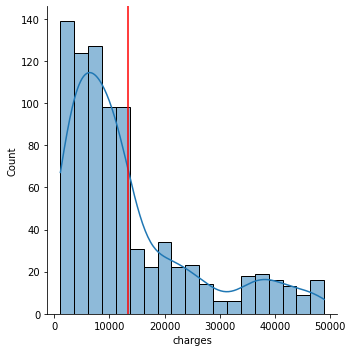

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

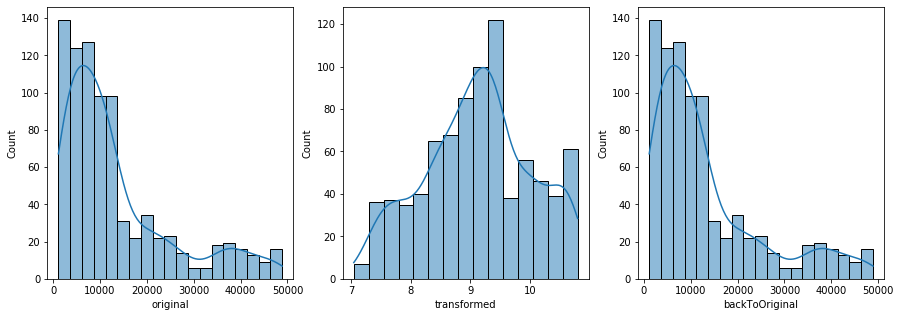

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 타겟의 분포
sns.displot(y_train, kde=True)
plt.axvline(baseline, color='red')
plt.show()

# 원본 plot, log-transform plot, inverse plot 
plots = pd.DataFrame()
plots['original'] = y_train
plots['transformed'] = np.log1p(y_train)   # ln(1 + x)
plots['backToOriginal'] = np.expm1(np.log1p(y_train))   # exp(x) - 1, the inverse of log1p.

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(plots['original'], kde=True, ax=ax[0]);
sns.histplot(plots['transformed'], kde=True, ax=ax[1]);
sns.histplot(plots['backToOriginal'], kde=True, ax=ax[2]);
plt.show()

# y_train을 log-transform
y_train_transformed = np.log1p(y_train)
y_train_cv_transformed = np.log1p(y_train_cv)

### 모델학습
1) Simple Linear Regression (단순 선형 회귀)
- R2 of train set : 0.7506463935828628
- R2 of validation set : 0.7442610624399132

2) 베이스라인
- R2 of train set : 0.0
- R2 of validation set : -0.002059934739899072



In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from category_encoders import OrdinalEncoder

# 단순 선형 회귀 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# 모델 인스턴스 생성
lr = LinearRegression()

# 모델 학습
lr.fit(X_train_encoded, y_train)

# LinearRegression 모델 학습 결과
y_pred = lr.predict(X_train_encoded)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = lr.predict(X_val_encoded)
print('R2 of validation set :', r2_score(y_val, y_pred))

# Baseline 모델 학습 결과
y_pred = [baseline] * len(y_train)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = [baseline] * len(y_val)
print('R2 of validation set :', r2_score(y_val, y_pred))

R2 of train set : 0.7506463935828628
R2 of validation set : 0.7442610624399132
R2 of train set : 0.0
R2 of validation set : -0.002059934739899072


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


3) Polynomial Regression (다항 회귀)
- R2 of train set : 0.8383378741243789
- R2 of validation set : 0.8393361420334535

In [8]:
from sklearn.preprocessing import PolynomialFeatures

# 다항 회귀 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# PolynomialFeatures
pf = PolynomialFeatures(degree=3)
X_train_pf = pf.fit_transform(X_train_encoded)
X_val_pf = pf.transform(X_val_encoded)

# LinearRegression
lr = LinearRegression()
lr.fit(X_train_pf, y_train)

# PolynomialRegression 모델 학습 결과
y_pred = lr.predict(X_train_pf)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = lr.predict(X_val_pf)
print('R2 of validation set :', r2_score(y_val, y_pred))

R2 of train set : 0.8383378741243789
R2 of validation set : 0.8393361420334535


4) Ridge Regression(RidgeCV)
- R2 of train set : 0.7505724641668234
- R2 of validation set : 0.744670418731205
- alpha : 0.01
- cv best score : 0.7434086572015769

In [9]:
from sklearn.linear_model import RidgeCV

# Ridge Regression 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# RidgeRegression(RidgeCV)
alphas = np.arange(0.01, 0.2, 0.01)

rcv = RidgeCV(alphas=alphas, normalize=True, scoring='r2', cv=5)
rcv.fit(X_train_encoded, y_train)

# RidgeRegression 모델 학습 결과
y_pred = rcv.predict(X_train_encoded)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = rcv.predict(X_val_encoded)
print('R2 of validation set :', r2_score(y_val, y_pred))
print(f'alpha : {rcv.alpha_}')
print(f'cv best score : {rcv.best_score_}')

R2 of train set : 0.7505724641668234
R2 of validation set : 0.744670418731205
alpha : 0.01
cv best score : 0.7434086572015769


5) Polynomial Regression (다항 회귀) + RidgeRegression(RidgeCV)
- R2 of train set : 0.8364335015567959
- R2 of validation set : 0.8499633123662965
- alpha : 0.01
- cv best score : 0.8210316487233381

In [10]:
from category_encoders import OrdinalEncoder

# 다항 회귀 + RidgeRegression 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# PolynomialFeatures
pf = PolynomialFeatures(degree=3)
X_train_pf = pf.fit_transform(X_train_encoded)

# RidgeRegression(RidgeCV)
alphas = np.arange(0.01, 0.2, 0.01)

rcv = RidgeCV(alphas=alphas, normalize=True, scoring='r2', cv=5)
rcv.fit(X_train_pf, y_train)

# Polynomial Regression + RidgeRegression 모델 학습 결과
y_pred = rcv.predict(X_train_pf)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = rcv.predict(X_val_pf)
print('R2 of validation set :', r2_score(y_val, y_pred))
print(f'alpha : {rcv.alpha_}')
print(f'cv best score : {rcv.best_score_}')

R2 of train set : 0.8364335015567959
R2 of validation set : 0.8499633123662965
alpha : 0.01
cv best score : 0.8210316487233381


6) DecisionTree Regression (회귀트리)
- R2 of train set : 0.8786381683660834
- R2 of validation set : 0.8620991137351688

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# 회귀트리 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# DecisionTreeRegressor
dtr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=6, min_samples_leaf=10)
dtr.fit(X_train_encoded, y_train)

# DecisionTreeRegressor 모델 학습 결과
y_pred = dtr.predict(X_train_encoded)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = dtr.predict(X_val_encoded)
print('R2 of validation set :', r2_score(y_val, y_pred))

R2 of train set : 0.8786381683660834
R2 of validation set : 0.8620991137351688


7) RandomForest Regression (랜덤포레스트)
- R2 of train set : 0.8833839474770703
- R2 of validation set : 0.8749069704418986

In [12]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# RandomForestRegressor
rfr = RandomForestRegressor(max_depth=10, min_samples_leaf=10, oob_score=True, n_jobs=-1)
rfr.fit(X_train_encoded, y_train)

# RandomForest Regression 모델 학습 결과
y_pred = rfr.predict(X_train_encoded)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = rfr.predict(X_val_encoded)
print('R2 of validation set :', r2_score(y_val, y_pred))

R2 of train set : 0.8842297772927424
R2 of validation set : 0.8746376117068155


8) Gradient Boost Tree (xgboost)
- R2 of train set : 0.9564105875368435
- R2 of validation set : 0.8481437565359133

[07:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14509.1	validation_1-rmse:13866.7
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:11929.9	validation_1-rmse:11381.8
[2]	validation_0-rmse:9892.45	validation_1-rmse:9434.26
[3]	validation_0-rmse:8282.2	validation_1-rmse:7954.64
[4]	validation_0-rmse:7033.57	validation_1-rmse:6835.95
[5]	validation_0-rmse:6044.42	validation_1-rmse:6065
[6]	validation_0-rmse:5284.52	validation_1-rmse:5463.5
[7]	validation_0-rmse:4679.72	validation_1-rmse:5081.82
[8]	validation_0-rmse:4217.14	validation_1-rmse:4817.58
[9]	validation_0-rmse:3832.19	validation_1-rmse:4634.28
[10]	validation_0-rmse:3542.74	validation_1-rmse:4535.13
[11]	validation_0-rmse:3284.6	validation_1-rmse:4491.8
[12]	validation_0-rmse:3107.19	validation_1-rms

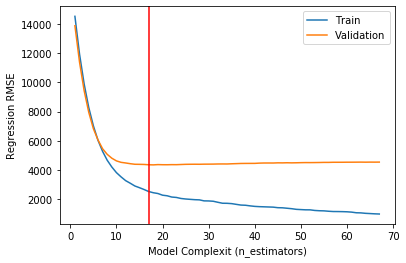


R2 of train set : 0.9564105875368435
R2 of validation set : 0.8481437565359133


In [13]:
from xgboost import XGBRegressor

# XGBRegressor 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# XGBRegressor
xgbr = XGBRegressor(n_estimators=1000,
                    max_depth=7,
                    learning_rate=0.2,
                    n_jobs=-1
                    )

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

xgbr.fit(X_train_encoded, y_train,
         eval_set=eval_set,
         eval_metric='rmse',
         early_stopping_rounds=50)

results = xgbr.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(1, len(train_rmse)+1)
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.ylabel('Regression RMSE')
plt.xlabel('Model Complexit (n_estimators)')
plt.legend();
plt.axvline(17, color='red')
plt.show()
print()

# Gradient Boost Tree (xgboost) 모델 학습 결과
y_pred = xgbr.predict(X_train_encoded)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = xgbr.predict(X_val_encoded)
print('R2 of validation set :', r2_score(y_val, y_pred))

9) Gradient Boost Tree (LightGBM)
- R2 of train set : 0.9049573960288514
- R2 of validation set : 0.8699611540247312

[1]	training's rmse: 9763.59	training's l2: 9.53278e+07	valid_1's rmse: 9285.51	valid_1's l2: 8.62208e+07
Training until validation scores don't improve for 50 rounds.
[2]	training's rmse: 8214.6	training's l2: 6.74796e+07	valid_1's rmse: 7824.35	valid_1's l2: 6.12205e+07
[3]	training's rmse: 7029.45	training's l2: 4.94132e+07	valid_1's rmse: 6722.98	valid_1's l2: 4.51984e+07
[4]	training's rmse: 6148.06	training's l2: 3.77986e+07	valid_1's rmse: 5919.05	valid_1's l2: 3.50352e+07
[5]	training's rmse: 5497.52	training's l2: 3.02227e+07	valid_1's rmse: 5310.32	valid_1's l2: 2.81995e+07
[6]	training's rmse: 5026.16	training's l2: 2.52623e+07	valid_1's rmse: 4878.73	valid_1's l2: 2.3802e+07
[7]	training's rmse: 4662.96	training's l2: 2.17432e+07	valid_1's rmse: 4592.81	valid_1's l2: 2.10939e+07
[8]	training's rmse: 4423.05	training's l2: 1.95634e+07	valid_1's rmse: 4389.77	valid_1's l2: 1.927e+07
[9]	training's rmse: 4246.8	training's l2: 1.80353e+07	valid_1's rmse: 4250.52	valid_1's l2: 1

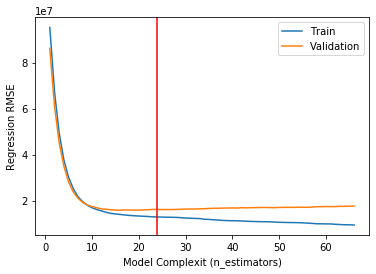


R2 of train set : 0.8990955460091421
R2 of validation set : 0.8735695672681261


In [14]:
from lightgbm import LGBMRegressor

# LGBMRegressor 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train)
X_val_encoded = oe.transform(X_val)

# LGBMRegressor
lgbmr = LGBMRegressor(n_estimators=1000,
                    max_depth=7,
                    learning_rate=0.2,
                    n_jobs=-1
                    )

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

lgbmr.fit(X_train_encoded, y_train,
         eval_set=eval_set,
         eval_metric='rmse',
         early_stopping_rounds=50)

results = lgbmr.evals_result_
train_rmse = results['training']['l2']
val_rmse = results['valid_1']['l2']
epoch = range(1, len(train_rmse)+1)
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.ylabel('Regression RMSE')
plt.xlabel('Model Complexit (n_estimators)')
plt.legend();
plt.axvline(24, color='red')
plt.show()
print()

# Gradient Boost Tree (xgboost) 모델 학습 결과
y_pred = lgbmr.predict(X_train_encoded)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = lgbmr.predict(X_val_encoded)
print('R2 of validation set :', r2_score(y_val, y_pred))

### 최종모델
- RandomForest Regression (랜덤포레스트)
- R2 of train set : 0.8830533481423402
- R2 of validation set : 0.8749501907988394
- R2 of test set : 0.8624664176717796

In [15]:
# 랜덤포레스트 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# RandomForestRegressor
rfr = RandomForestRegressor(max_depth=10, min_samples_leaf=10, oob_score=True, n_jobs=-1)
rfr.fit(X_train_encoded, y_train)

# RandomForest Regression 모델 학습 결과
y_pred = rfr.predict(X_train_encoded)
print('R2 of train set :', r2_score(y_train, y_pred))
y_pred = rfr.predict(X_val_encoded)
print('R2 of validation set :', r2_score(y_val, y_pred))

# test
X_test_encoded = oe.transform(X_test)
y_pred = rfr.predict(X_test_encoded)
print('R2 of test set :', r2_score(y_test, y_pred))

R2 of train set : 0.8832337778599717
R2 of validation set : 0.8730472876756417
R2 of test set : 0.8623342251751678


### 최종모델 설명
- PDP
- 'age'특성값이 증가함에 따라서 타겟값('charges')이 증가한다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


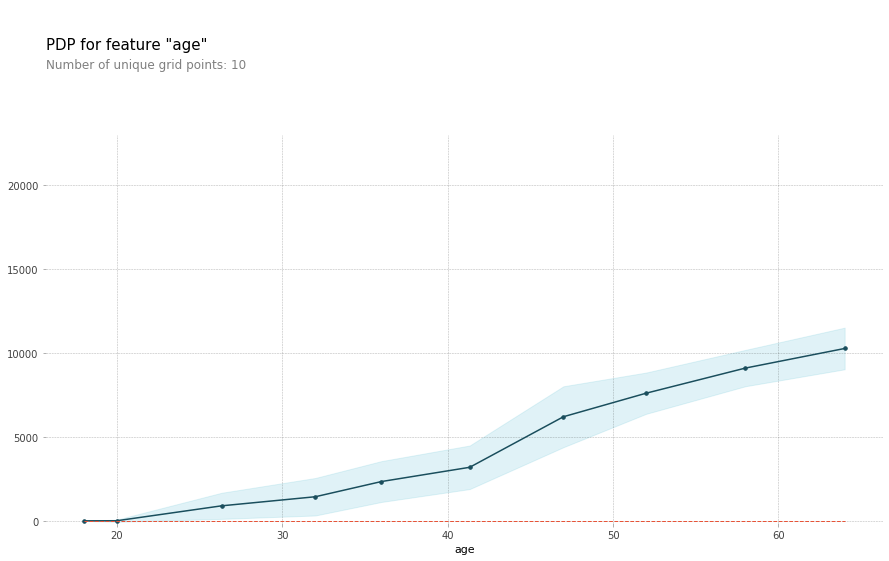

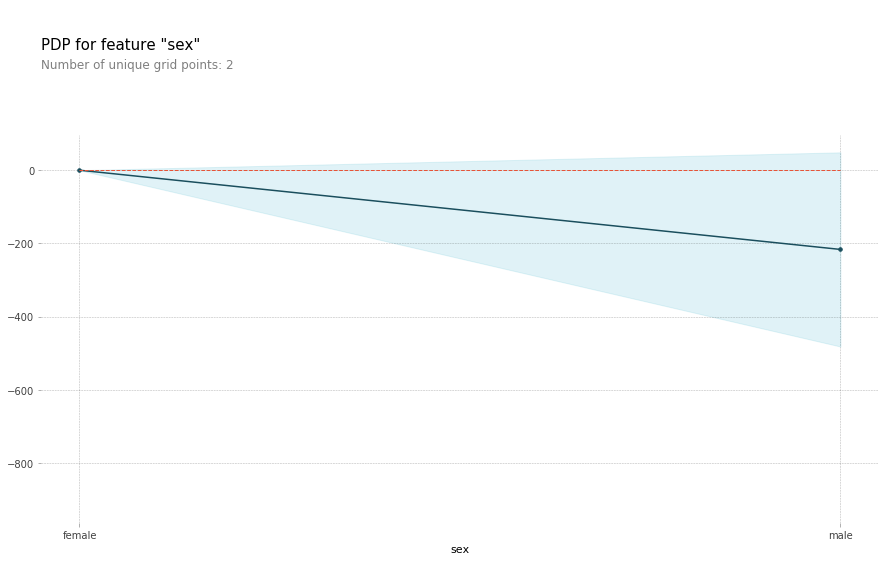

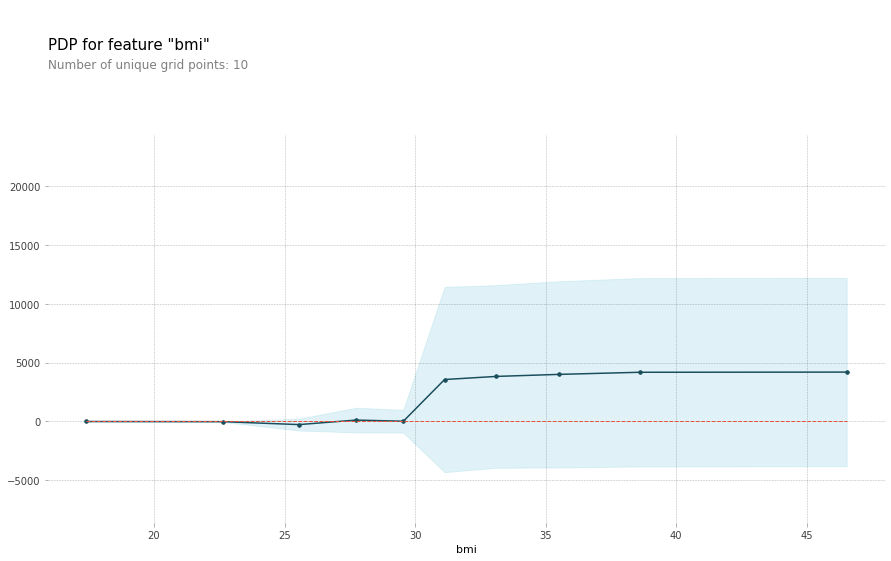

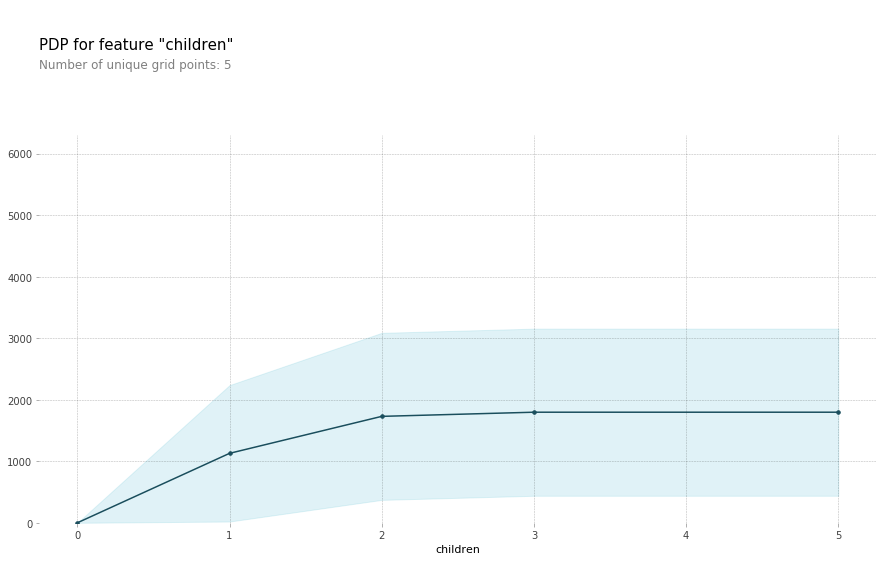

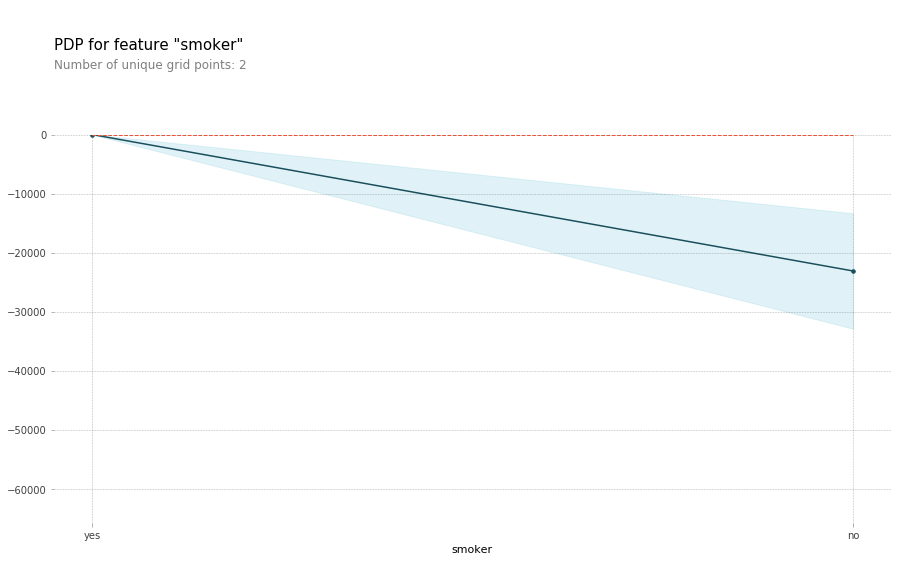

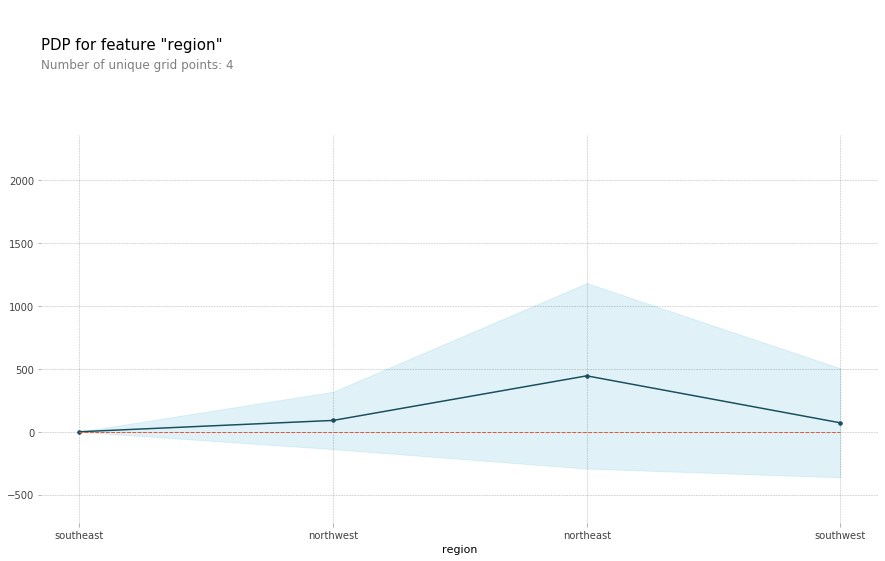

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


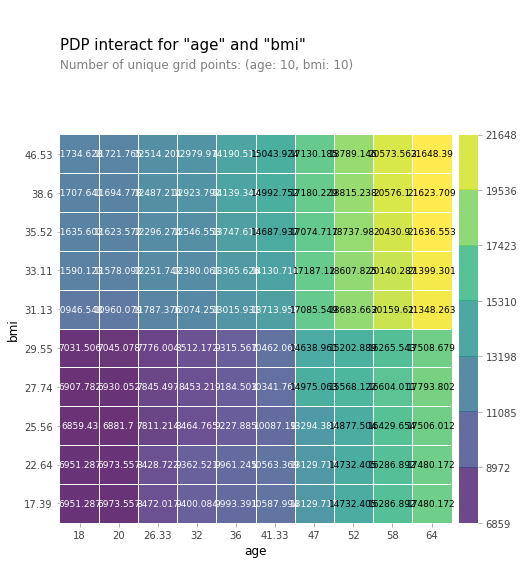

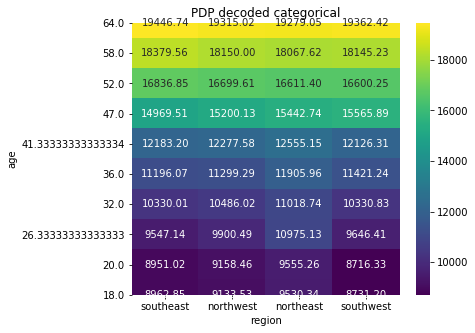

In [16]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

categoryfeature = list()
for item in oe.mapping:
  categoryfeature.append(item['col'])

def drawpdp(f):
  feature = f

  if feature in categoryfeature:
    for item in oe.mapping:
      if item['col'] == feature:
        feature_mapping = item['mapping'] # Series

    feature_mapping = feature_mapping[feature_mapping.index.dropna()]
    category_names = feature_mapping.index.tolist()
    category_codes = feature_mapping.values.tolist()

  isolated = pdp_isolate(     
      model=rfr,
      dataset=X_val_encoded,
      model_features=X_val.columns,
      feature=feature,
      grid_type='percentile',   # default='percentile', or 'equal'
      num_grid_points=10   # default=10
  )

  pdp_plot(isolated, feature_name=f)
  # xticks labels 설정을 위한 리스트
  if feature in categoryfeature:
    plt.xticks(category_codes, category_names);
  plt.show()

for column in X_train.columns:
  drawpdp(column)

# 두 특성('age', 'bmo')간 관계에 대한 PDP
features = ['age', 'bmi']

interaction = pdp_interact(
    model=rfr,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features);
plt.show()

# 두 특성('age', 'region')간 관계에 대한 PDP
features = ['age', 'region']

for item in oe.mapping:
  if item['col'] == 'region':
    feature_mapping = item['mapping'] # Series

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

interaction = pdp_interact(
    model=rfr,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=features
)

pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[1],
    index=features[0]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(6, 5))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP decoded categorical');
plt.show()

- SHAP
- 영향을 크게 주는 순서 : 'smoker', 'age', 'bmi', 'children', 'region', 'sex'

In [17]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(rfr)

### Draw SHAP plots ###
# force_plot
shap_values = explainer.shap_values(X_val_encoded.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_val.iloc[:100])

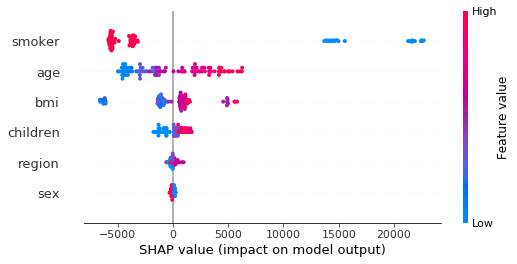

In [18]:
# summary_plot
shap.summary_plot(shap_values, X_val_encoded.iloc[:100])

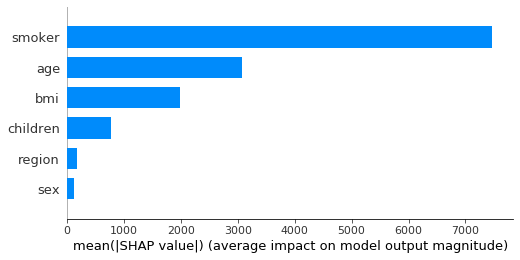

In [19]:
# summary_plot
shap.summary_plot(shap_values, X_val_encoded.iloc[:100], plot_type="bar")

### 결론
- 현재 예상되는 국가의 보장금액 : 12783.67
- 흡연 인구의 비율 10 % 감소한 경우 예상되는 국가의 보장금액 : 10506.67 (약 19% 감소)
- 연령별 인구구성 비율이 10년이 고령화 되었을 때 예상되는 국가의 보장금액 :14902.13 (약 17% 증가)

In [24]:
# 랜덤포레스트 모델

# 인코더 인스턴스 생성
oe = OrdinalEncoder()
X_train_encoded = oe.fit_transform(X_train, y_train)
X_val_encoded = oe.transform(X_val)

# RandomForestRegressor
rfr = RandomForestRegressor(max_depth=10, min_samples_leaf=10, oob_score=True, n_jobs=-1)
rfr.fit(X_train_encoded, y_train)

# test
X_test_encoded = oe.transform(X_test)
y_pred = rfr.predict(X_test_encoded)
print('현재 예상되는 국가의 보장금액 :', y_pred.mean())

X_test_quit = X_test.copy()
n = len(X_test_quit) * 0.1
cnt = 0
for i in range(len(X_test_quit['smoker'])):
  if cnt > n:
    break
  elif X_test_quit['smoker'].iloc[i] == 'yes':
    X_test_quit['smoker'].iloc[i] ='no'
    cnt += 1
X_test_quit_encoded = oe.transform(X_test_quit)
y_pred2 = rfr.predict(X_test_quit_encoded)
print('흡연 인구의 비율 10 % 감소한 경우 예상되는 국가의 보장금액 :', y_pred2.mean())
print('현재 대비 :', y_pred2.mean()-y_pred.mean())

X_test_old = X_test.copy()
X_test_old['age'] = X_test_old['age'] + 10
X_test_old_encoded = oe.transform(X_test_old)
y_pred3 = rfr.predict(X_test_old_encoded)
print('연령별 인구구성 비율이 10년이 고령화 되었을 때 예상되는 국가의 보장금액 :', y_pred3.mean())
print('현재 대비 :', y_pred3.mean()-y_pred.mean())

현재 예상되는 국가의 보장금액 : 12783.67575852347
흡연 인구의 비율 10 % 감소한 경우 예상되는 국가의 보장금액 : 10506.672590588647
현재 대비 : -2277.003167934823
연령별 인구구성 비율이 10년이 고령화 되었을 때 예상되는 국가의 보장금액 : 14902.135241810412
현재 대비 : 2118.4594832869425
